In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
#Quantum Monte Carlo - Diffusion

class dmc:
    
    def __init__(self, num_walkers_start=2000, target_walkers=2000, walkers_start_position =0.0,
                 num_steps = 1000, time_step = 0.1, e_r= 0., burn_in = 300, num_bins = 50, 
                 x_min = -10, x_max = 10, potential_type = 'harmonic'):
        
        #Initialization
        self.num_walkers_start =  num_walkers_start              #how many walkers to initialize at t=0
        self.walkers_start_position = walkers_start_position     #initial delta function position for walkers
        self.target_walkers = target_walkers                     #preferred number of walkers at equilibrium
        self.num_steps = num_steps                               #number of iterations of the simulation to run
        self.time_step = time_step                               #the unit of imaginary time between each step
        self.e_r = e_r                                           #the initial guess for the reference energy
        self.burn_in = burn_in                                   #how many iterations needed to reach equilibrium
        self.num_bins = num_bins                                 #the number of bins in the wavefunction histogram
        self.x_min = x_min                                       #the minimum of the histogram x range
        self.x_max = x_max                                       #the maximum of the histogram x range
        self.potential_type = potential_type                     #which potential function to use
        
        self.walkers = np.full(num_walkers_start, walkers_start_position)
        
    def potential(self):
        """Determines which included potential function to evaluate. Current choices: simple harmonic oscillator
        and morse potential"""
        
        if self.potential_type == 'harmonic':
            v = self.potential_harmonic()
        if self.potential_type == 'morse':
            v =self.potential_morse()
        return v

    def potential_harmonic(self):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
        """      
        v = 0.5*self.walkers**2
        return v

    def potential_morse(self):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
                a     :: defining parameter - will be set to 1 for ease of solution
        """
        a = 1.
        v = 0.5*(np.exp( -2*a*self.walkers ) - 2*np.exp( -a*self.walkers ) )
        return v

    def run_dmc(self):
        """Simulates a quantum system using the quantum diffusion method"""
        wave_function = np.zeros(self.num_bins)
        e_0 = []
        
        for i in range(self.num_steps):
            #Perform a random walk
            for j in range(self.walkers.size):
                self.walkers[j] += np.random.normal() * np.sqrt(self.time_step)
            
            #Determine the weight function
            num_walkers_old = self.walkers.size
            energy = np.zeros_like(self.walkers)                                       #finding the weight for each walker
            energy = 1. -(self.potential() - self.e_r) * self.time_step + np.random.random()
            weight = np.int_(energy)                                              #convert to int per the algorithm
            new_walkers = np.zeros_like(self.walkers)                                  #how many new walkers each walker spawns
            new_walkers = np.minimum(3, weight)

            #Make a new array of walkers
            keep = np.compress(new_walkers > 0, self.walkers)        #get an array of each walker still existing
            duplicate1 = np.compress(new_walkers > 1, self.walkers)  #get an array of each walker duplicated
            duplicate2 = np.compress(new_walkers > 2, self.walkers)  #get an array of each walker twice duplicated
            self.walkers = np.append(keep, duplicate1)                  #combine the above arrays into a complete array of walkers
            self.walkers = np.append(self.walkers, duplicate2)
            
            #Once burn-in is complete, add values to the histogram
            if i>self.burn_in:
                hist, bin_edges = np.histogram(self.walkers, bins=self.num_bins, range=(self.x_min, self.x_max))
                wave_function += hist                                            #add the walker distribution at this step to the total distribution
            e_0.append(np.mean(self.potential()))                                       #E_0 estimate at this step

            #Adjust values for next iteration
            self.e_r = np.mean(self.potential()) - (self.walkers.size - self.target_walkers) / (self.target_walkers )      #NEED TO CHECK UNITS
            
        return wave_function, bin_edges, e_0


0.476372874161 0.170349669628


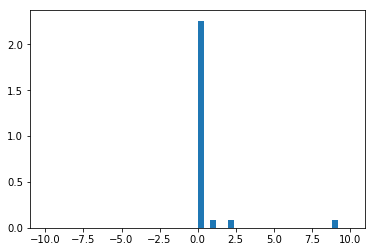

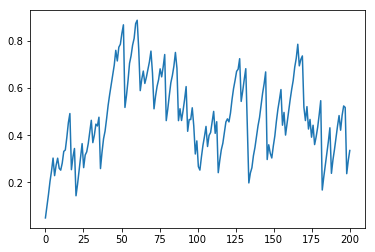

In [32]:
dmc_test_1 = dmc(num_steps = 200, burn_in = 40)
wave, bins, e0 = dmc_test_1.run_dmc()

plt.figure(0)
plt.hist(wave, bins=bins, normed =True)

trial = np.linspace(0, len(e0), len(e0))
plt.figure(1)
plt.plot(trial, e0)

print(np.mean(e0), np.std(e0))

-0.217387607378 0.0759550345734


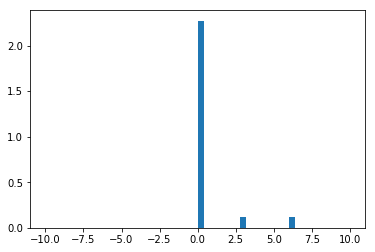

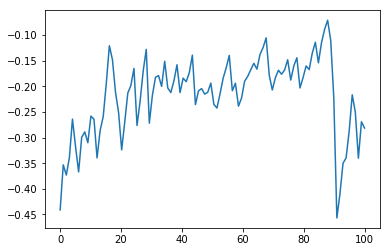

In [36]:
dmc_test_2 = dmc(num_steps = 100, burn_in = 40, potential_type = 'morse')
wave, bins, e0 = dmc_test_2.run_dmc()

plt.figure(0)
plt.hist(wave, bins=bins, normed=True)

trial = np.linspace(0, len(e0), len(e0))
plt.figure(1)
plt.plot(trial, e0)

print(np.mean(e0), np.std(e0))